# Part5: Model validation

data is taken from https://www.kaggle.com/c/santander-customer-transaction-prediction

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.

In this notebook we validate ML model and prepare file forsubmition to kaggle

## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.constraints import max_norm
from keras.models import model_from_json

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Load data

In [2]:
#load oversampled data after ETL
X_val = np.load("X_val_samp_std.npy")
Y_val = np.load("Y_val_samp.npy")
#X_train_orig = np.load("X_train_orig_std.npy")
#Y_train_orig = np.load("Y_train_orig.npy")
#X_test = np.load("X_test_std.npy")

print (X_val.shape)
print (Y_val.shape)
#X_test = np.fromfile("X_test_std")

(60000, 200)
(60000,)


In [3]:
#Sample half of the datasets (before over-sampling) for validations
#X_train_NN ,X_val_NN ,Y_train_NN , Y_val_NN = train_test_split(X_train_orig,Y_train_orig,test_size=0.5,random_state=45)

## Check of performance
Useful functions to check performance of the model

In [4]:
# useful function from 
# https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py
import itertools

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

## Load trained model

In [5]:
# load json and create model
#name_ext = "1551624345.9946399"#32, 1000 epoch,  accuracy score: 0.7842128450612154
#name_ext = '1551635924.673968' #32, accuracy score:0.816, misid 0 as 1: 14%, misid 1 as 0: 23%; 
#name_ext = '1551636560.3656414' #32, accuracy score:0.813, misid 0 as 1: 12%, misid 1 as 0: 26%;

#name_ext = '1551638869.150083'#64, accuracy score:0.817, misid 0 as 1: 12%, misid 1 as 0: 25%;

#name_ext = '1551640650.8077817' #128, accuracy score: 0.838, misid 0 as 1: 5%, misid 1 as 0: 27%;
#name_ext = '1551641103.5993311' #128, accuracy score:0.856, misid 0 as 1: 7%, misid 1 as 0: 22%;
name_ext = '1551991503.568746'
json_file = open("model_NN_32_ts"+name_ext+".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_NN_32 = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_NN_32.load_weights("model_NN_32_ts"+name_ext+".h5")
print("Loaded model_NN_32 from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model_NN_32 from disk


## Evaluate loaded model on test data

In [6]:
Y_pred = loaded_model_NN_32.predict(X_val)
for i in range(len(Y_pred)):
    if Y_pred[i]<0.5:
        Y_pred[i] = int(0)
    else:
        Y_pred[i] = int(1)

In [7]:
print ("accuracy score:",balanced_accuracy_score(Y_val, Y_pred))

accuracy score: 0.7241571980406205


[[45679  8314]
 [ 2389  3618]]

misid 0 as 1: 15.398292371233309
misid 1 as 0: 39.77026802064258


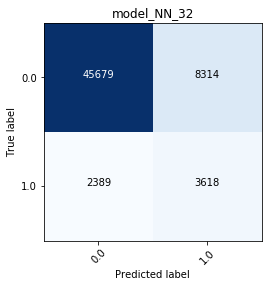

In [8]:
cm_tree = confusion_matrix(Y_val, Y_pred)
fig, ax = plt.subplots()

plot_confusion_matrix(cm_tree, classes=np.unique(Y_pred), ax=ax,title='model_NN_32')
print("misid 0 as 1:", (100*cm_tree[0,1])/float(cm_tree[0,0]+cm_tree[0,1]))
print("misid 1 as 0:", (100*cm_tree[1,0])/float(cm_tree[1,0]+cm_tree[1,1]))


## Conclusion, observations

* NN with 32 input layers and batch size 4*512 performance:
 * 10 epoch: balanced_score=0.78, type0 is misidentified as type1 in 21%, type1 misidentified as type0 in 21% 
 * 100 epoch:  balanced_score=0.77, type0 is misidentified as type1 in 12%, type1 misidentified as type0 in 33%
 Overfiting!